In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import xgboost as xg
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope as ho_scope

In [2]:
# Importar la data
data = pd.read_csv('data.csv')

In [3]:
x = data.drop('actual_productivity', axis=1)
y = data['actual_productivity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=127, random_state=10)

### Modelo simple

In [4]:
# Definir el modelo XGBoost
model_xg = xg.XGBRegressor(random_state=10, eval_metric='mae')

In [5]:
# Los parámetros que el modelo utiliza son

print('Parámetros por defecto del modelo:\n')
print(model_xg.get_params())

Parámetros por defecto del modelo:

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mae', 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 10, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [6]:
start = dt.now()
# Ajustar el modelo al conjunto de datos de entrenamiento
model_xg.fit(x_train, y_train)
end = dt.now()

In [7]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

0

In [8]:
# Valores predichos por el modelo
y_pred_train = model_xg.predict(x_train)
y_pred_test = model_xg.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train = mean_absolute_error(y_train, y_pred_train)
error_test = mean_absolute_error(y_test, y_pred_test)

In [9]:
# Se observa al aplicar un modelo xgboost con sus parámetros por defecto
# el MAE para el conjunto de entrenamiento es de 0.01 y en el conjunto de pruebas es de 0.0785

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test))

MAE del conjunto de entrenamiento: 0.0142729
MAE del conjunto de prueba: 0.0784539


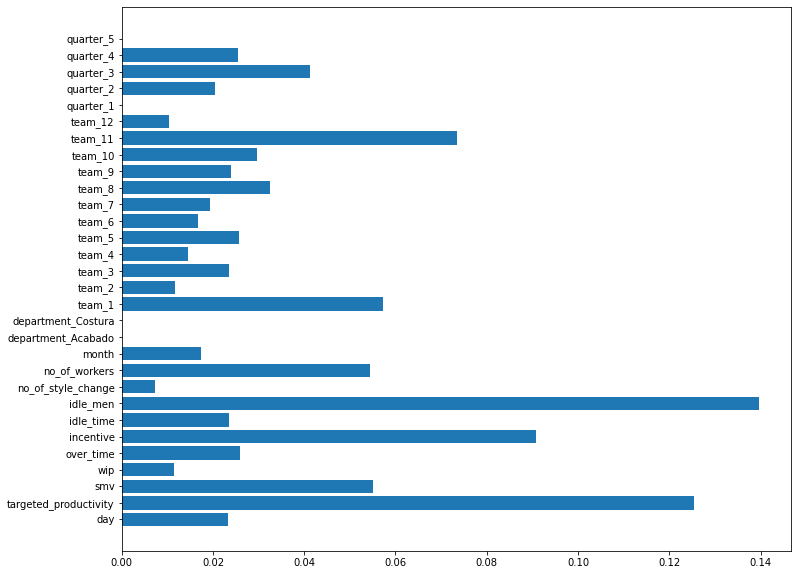

In [10]:
# Importancia de las variables para estimar la productividad

plt.figure(figsize=(12,10))
plt.barh(x_train.columns, model_xg.feature_importances_)
plt.show()

### Modelo con ajuste de hiper parámetros

#### Grid search

In [11]:
# Crear la grilla de parámetros
param_grid = {
    'max_depth': [3, 10, 20, 30]
     ,'min_child_weight': [1, 5, 10]
#      ,'gamma': [0.05, 2, 5]
#      ,'eta': [0, 0.1, 0.2, 0.5]
     ,'subsample': [0.1, 0.5, 0.8, 1]
     ,'colsample_bytree': [0.1, 0.5, 0.8, 1]
}

In [12]:
# Definir el modelo XGBoost
model_xg = xg.XGBRegressor(random_state=10, eval_metric='mae',seed = 10)

In [13]:
grid_search = GridSearchCV(estimator = model_xg
             , param_grid = param_grid
             , cv = 10
             , n_jobs = -1)

In [14]:
start = dt.now()
grid_search.fit(x_train, y_train)
end = dt.now()

In [15]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

2893

In [16]:
grid_search.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.1,
 'gamma': 0.05,
 'max_depth': 20,
 'min_child_weight': 1,
 'subsample': 0.8}

In [17]:
best_grid = grid_search.best_estimator_

In [18]:
joblib.dump(best_grid, 'resultados/xgboost_grid.pkl')

['resultados/xgboost_grid.pkl']

In [19]:
# Valores predichos por el modelo
y_pred_train_grid = best_grid.predict(x_train)
y_pred_test_grid = best_grid.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
error_test_grid = mean_absolute_error(y_test, y_pred_test_grid)

In [20]:
# Se observa al aplicar un modelo XGBoost con un ajuste de hiper parámetros
# el MAE para el conjunto de entrenamiento es de 0.0421 y en el conjunto de pruebas es de 0.065

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train_grid))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test_grid))

MAE del conjunto de entrenamiento: 0.0498930
MAE del conjunto de prueba: 0.0701750


#### Optimización bayesiana

In [4]:
def optimize(search_space):
    model = xg.XGBRegressor(**search_space)
    scores = cross_val_score(model, X=x_train, y=y_train, cv=10, scoring='neg_mean_absolute_error').mean()
    
    return {'loss':scores, 'status': STATUS_OK, 'model': model}

In [5]:
search_space = {
    'eval_metric': 'mae',
    'seed': 10,
    'max_depth': ho_scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'min_child_weight': ho_scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
#     'gamma': hp.quniform('gamma', 0.05, 5, 0.05),
#     'eta': hp.quniform('eta', 0, 0.5, 0.05),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsasmple_bytree', 0.1, 1, 0.1)
}

optimization_function = partial(
    optimize
)

In [23]:
trials = Trials()
start = dt.now()

result = fmin(
    fn = optimization_function
    , space = search_space
    , max_evals = 200
    , trials=trials
    , algo = tpe.suggest
)

end = dt.now()

100%|██████████| 200/200 [09:14<00:00,  2.77s/trial, best loss: -0.2630280669747664]


In [24]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

554

In [25]:
print(space_eval(search_space, result))

{'colsample_bytree': 0.1, 'eta': 0.0, 'eval_metric': 'mae', 'gamma': 0.65, 'max_depth': 7, 'min_child_weight': 7, 'seed': 10, 'subsample': 0.6000000000000001}


In [26]:
best_model_bo = trials.best_trial['result']['model']

In [27]:
joblib.dump(best_model_bo, 'resultados/xgboost_bo.pkl')

['resultados/xgboost_bo.pkl']

In [28]:
best_model_bo.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.0,
             eval_metric='mae', gamma=0.65, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=0,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
             max_leaves=0, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=10,
             reg_alpha=0, ...)

In [29]:
# Valores predichos por el modelo
y_pred_train_bo = best_model_bo.predict(x_train)
y_pred_test_bo = best_model_bo.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train_bo = mean_absolute_error(y_train, y_pred_train_bo)
error_test_bo = mean_absolute_error(y_test, y_pred_test_bo)

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train_bo))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test_bo))

MAE del conjunto de entrenamiento: 0.2630281
MAE del conjunto de prueba: 0.2678626


In [30]:
# trials.losses()

In [31]:
joblib.dump(trials, 'resultados/xgoost_bo_trials.pkl')

['resultados/xgoost_bo_trials.pkl']